In [1]:
#Importando biblioteca
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Lendo e visualizando a base e dropando a primera a coluna
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [3]:
# testando de um modo que nao traga resultados satisfatório, onde as classes estao ordenaddas por padrão
dados_azar = dados.sort_values("vendido", ascending=True) #ordenando

#Separando os dados em x e y
x_azar = dados_azar[["preco", "idade_do_modelo", "km_por_ano"]]
y_azar = dados_azar["vendido"]

dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [4]:
#utilizando a validação cruzada e dummy classifier para estratificar a quantidade de  0 e 1 e verificar a proporçao disso nos dados
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

#definindo a semente
SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv =10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratifield , 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao)*100))

Accuracy com dummy stratifield , 10 = [58.00, 58.00]


In [5]:
#utilizando a validação cruzada com um algoritmo mais inteligente e verificar se realmente nosso baseline é confiavel 
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

#definindo a semente
SEED = 301
np.random.seed(SEED)

modelo =  DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv =10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com validação cruzada , 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao)*100))

Accuracy com validação cruzada , 10 = [73.83, 77.73]


### Gerando dados aleatorios de modelo de carro para simulação de agrupamento ao usar o estimador

In [6]:
np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3 , size = 10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1 #transformandos os valores em positivo aumentando mais um ano
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [7]:
#criando uma função para facilitar ao printar os dados
def imprime_resultados(results):
    media = results['test_score'].mean()  * 100
    desvio_padrao = results['test_score'].std() *100
    print("Acurácia média %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio_padrao, media + 2 * desvio_padrao))

In [8]:
#### Grupo Kfold para analisar como o modelo se comporta com novos grupos
from sklearn.model_selection import GroupKFold

np.random.seed(SEED)

cv = GroupKFold(n_splits=10) # treinando 10 vezes o modelo
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups = dados.modelo, return_train_score=False) 
imprime_resultados(results)

Acurácia média 75.78
Intervalo [73.67, 77.90]


#### Grupo KFOLD em um pipeline com StandardScaler e SVC

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao', scaler), ('estimador', modelo)])

cv = GroupKFold(n_splits=10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Acurácia média 76.68
Intervalo [74.28, 79.08]


In [10]:
#Rodando novamente

#### Grupo Kfold para analisar como o modelo se comporta com novos grupos
from sklearn.model_selection import GroupKFold

np.random.seed(SEED)

cv = GroupKFold(n_splits=10) #treinando 10 vezes o modelo
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups = dados.modelo, return_train_score=False) #Implementando 10 vezes a validação cruzada
imprime_resultados(results)

Acurácia média 75.78
Intervalo [73.67, 77.90]


### Plotando a árvore

In [11]:
from sklearn.tree import  export_graphviz
import graphviz
!pip install graphviz

In [12]:
!pip install pydot

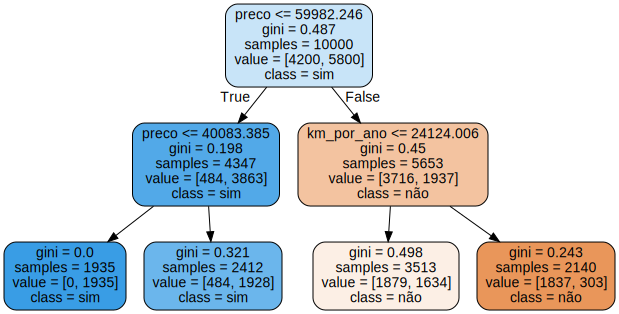

In [13]:
modelo.fit(x_azar, y_azar) #Antes de gerar a árvoce precisa difinir o fit(modelo treinando)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=["não", "sim"],
               feature_names=features)

graph = graphviz.Source(dot_data)
graph

In [14]:
#Rodando novamente mas alterando de dois nós para 3

#### Grupo Kfold para analisar como o modelo se comporta com novos grupos
from sklearn.model_selection import GroupKFold

np.random.seed(SEED)

cv = GroupKFold(n_splits=10) #treinando 10 vezes o modelo
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups = dados.modelo, return_train_score=False) #Implementando 10 vezes a validação cruzada
imprime_resultados(results)

Acurácia média 78.67
Intervalo [76.40, 80.94]


Tivemos uma melhora com 3 nós

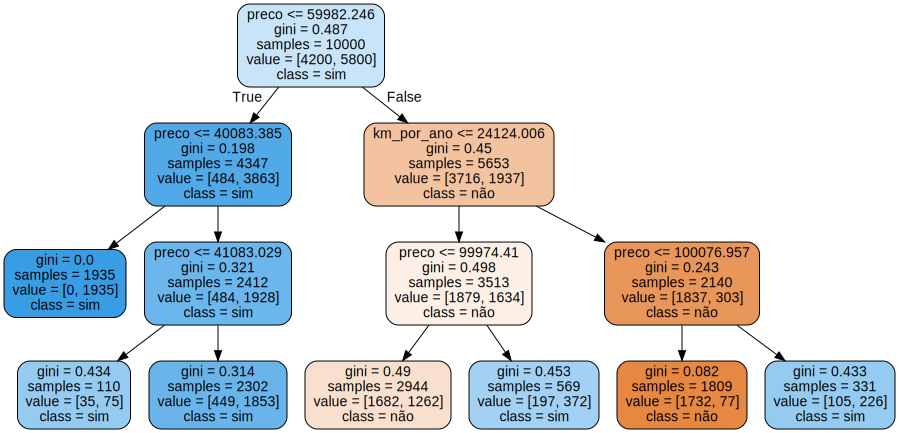

In [15]:
# agora com 3 nós
modelo.fit(x_azar, y_azar) #Antes de gerar a árvoce precisa difinir o fit(modelo treinando)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=["não", "sim"],
               feature_names=features)

graph = graphviz.Source(dot_data)
graph

### Explorando  Hiperparâmetros em uma dimensão

##### Teste

In [16]:
#Criando uma função da arvore de acordo com nós 
def roda_arvore_de_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10) #treinando 10 vezes o modelo
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups = dados.modelo, return_train_score=False) #sem os dados de treino
    print("max_depth = %d, media = %.2f" % (max_depth, results['test_score'].mean() * 100)) #dados de teste

    #Rodando a arvore de 1 a  32 no max_depth
for i in range(1,33):
    roda_arvore_de_decisao(i)

max_depth = 1, media = 75.78
max_depth = 2, media = 75.78
max_depth = 3, media = 78.67
max_depth = 4, media = 78.63
max_depth = 5, media = 78.56
max_depth = 6, media = 78.12
max_depth = 7, media = 77.96
max_depth = 8, media = 77.86
max_depth = 9, media = 77.38
max_depth = 10, media = 77.19
max_depth = 11, media = 76.97
max_depth = 12, media = 76.49
max_depth = 13, media = 75.81
max_depth = 14, media = 75.66
max_depth = 15, media = 75.16
max_depth = 16, media = 75.11
max_depth = 17, media = 74.74
max_depth = 18, media = 74.33
max_depth = 19, media = 74.34
max_depth = 20, media = 74.22
max_depth = 21, media = 73.80
max_depth = 22, media = 73.81
max_depth = 23, media = 73.38
max_depth = 24, media = 73.43
max_depth = 25, media = 73.14
max_depth = 26, media = 73.04
max_depth = 27, media = 72.91
max_depth = 28, media = 72.66
max_depth = 29, media = 72.73
max_depth = 30, media = 72.81
max_depth = 31, media = 72.86
max_depth = 32, media = 72.52


Nossa árvore e muito boa para dados de treino, mas para teste não, pois queremos que com mais decisões ela tenha resultados perfeitos e isso nao acontece

##### Treino

In [17]:
#Criando uma função da arvore de acordo com nós 
def roda_arvore_de_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10) #treinando 10 vezes o modelo
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups = dados.modelo, return_train_score=True) #sem os dados de treino
    print("max_depth = %d, media = %.2f" % (max_depth, results['train_score'].mean() * 100)) #dados de teste

    #Rodando a arvore de 1 a  32 no max_depth
for i in range(1,33):
    roda_arvore_de_decisao(i)

max_depth = 1, media = 75.79
max_depth = 2, media = 75.79
max_depth = 3, media = 78.75
max_depth = 4, media = 78.79
max_depth = 5, media = 78.94
max_depth = 6, media = 79.17
max_depth = 7, media = 79.50
max_depth = 8, media = 79.89
max_depth = 9, media = 80.46
max_depth = 10, media = 81.16
max_depth = 11, media = 82.03
max_depth = 12, media = 82.89
max_depth = 13, media = 83.95
max_depth = 14, media = 85.03
max_depth = 15, media = 86.14
max_depth = 16, media = 87.19
max_depth = 17, media = 88.31
max_depth = 18, media = 89.26
max_depth = 19, media = 90.32
max_depth = 20, media = 91.32
max_depth = 21, media = 92.14
max_depth = 22, media = 93.02
max_depth = 23, media = 93.80
max_depth = 24, media = 94.47
max_depth = 25, media = 95.16
max_depth = 26, media = 95.74
max_depth = 27, media = 96.33
max_depth = 28, media = 96.75
max_depth = 29, media = 97.10
max_depth = 30, media = 97.43
max_depth = 31, media = 97.80
max_depth = 32, media = 98.10


##### Arvore com dados de treino e teste

In [18]:
#Criando uma função da arvore de acordo com nós 
def roda_arvore_de_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10) #treinando 10 vezes o modelo
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups = dados.modelo, return_train_score=True) 
    print("max_depth = %d,treino = %.2f, teste = %.2f" % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100)) #dados de teste e treino

    #Rodando a arvore de 1 a  32 no max_depth
for i in range(1,33):
    roda_arvore_de_decisao(i)

max_depth = 1,treino = 75.79, teste = 75.78
max_depth = 2,treino = 75.79, teste = 75.78
max_depth = 3,treino = 78.75, teste = 78.67
max_depth = 4,treino = 78.79, teste = 78.63
max_depth = 5,treino = 78.94, teste = 78.56
max_depth = 6,treino = 79.17, teste = 78.12
max_depth = 7,treino = 79.50, teste = 77.96
max_depth = 8,treino = 79.89, teste = 77.86
max_depth = 9,treino = 80.46, teste = 77.38
max_depth = 10,treino = 81.16, teste = 77.19
max_depth = 11,treino = 82.03, teste = 76.97
max_depth = 12,treino = 82.89, teste = 76.49
max_depth = 13,treino = 83.95, teste = 75.81
max_depth = 14,treino = 85.03, teste = 75.66
max_depth = 15,treino = 86.14, teste = 75.16
max_depth = 16,treino = 87.19, teste = 75.11
max_depth = 17,treino = 88.31, teste = 74.74
max_depth = 18,treino = 89.26, teste = 74.33
max_depth = 19,treino = 90.32, teste = 74.34
max_depth = 20,treino = 91.32, teste = 74.22
max_depth = 21,treino = 92.14, teste = 73.80
max_depth = 22,treino = 93.02, teste = 73.81
max_depth = 23,trei

In [19]:
#Criando uma função da arvore de acordo com nós 
def roda_arvore_de_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10) #treinando 10 vezes o modelo
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups = dados.modelo, return_train_score=True) 
    train_score = results['train_score'].mean() *100
    test_score = results['test_score'].mean() *100
    print("max_depth = %d,treino = %.2f, teste = %.2f" % (max_depth, train_score, test_score)) #dados de teste e treino
    tabela = [max_depth, train_score, test_score]
    return tabela
    
 #Rodando a arvore de 1 a  32 no max_depth como list comprehension
resultados = [roda_arvore_de_decisao (i) for i in range(1,33)] 
#criando um dataframe com os resultados
resultados = pd.DataFrame(resultados, columns =["max_depth", "train", "test"])
resultados.head()

max_depth = 1,treino = 75.79, teste = 75.78
max_depth = 2,treino = 75.79, teste = 75.78
max_depth = 3,treino = 78.75, teste = 78.67
max_depth = 4,treino = 78.79, teste = 78.63
max_depth = 5,treino = 78.94, teste = 78.56
max_depth = 6,treino = 79.17, teste = 78.12
max_depth = 7,treino = 79.50, teste = 77.96
max_depth = 8,treino = 79.89, teste = 77.86
max_depth = 9,treino = 80.46, teste = 77.38
max_depth = 10,treino = 81.16, teste = 77.19
max_depth = 11,treino = 82.03, teste = 76.97
max_depth = 12,treino = 82.89, teste = 76.49
max_depth = 13,treino = 83.95, teste = 75.81
max_depth = 14,treino = 85.03, teste = 75.66
max_depth = 15,treino = 86.14, teste = 75.16
max_depth = 16,treino = 87.19, teste = 75.11
max_depth = 17,treino = 88.31, teste = 74.74
max_depth = 18,treino = 89.26, teste = 74.33
max_depth = 19,treino = 90.32, teste = 74.34
max_depth = 20,treino = 91.32, teste = 74.22
max_depth = 21,treino = 92.14, teste = 73.80
max_depth = 22,treino = 93.02, teste = 73.81
max_depth = 23,trei

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


### Visualizando

In [20]:
import seaborn as sns

##### ddos de treino

<AxesSubplot:xlabel='max_depth', ylabel='train'>

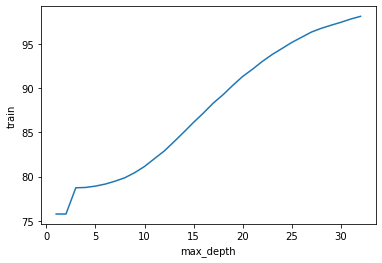

In [21]:
sns.lineplot(x = "max_depth", y="train", data = resultados )

##### dados de teste

<AxesSubplot:xlabel='max_depth', ylabel='test'>

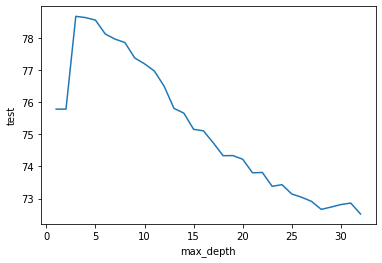

In [22]:
sns.lineplot(x = "max_depth", y="test", data = resultados )

### Overfit: Ficou "perfeito" para treino mas o ruim para o teste

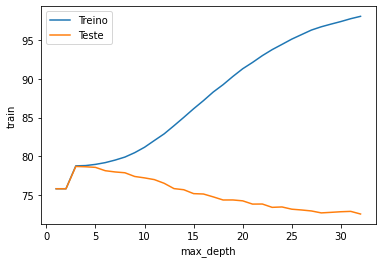

In [23]:
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth", y="train", data = resultados )
sns.lineplot(x = "max_depth", y="test", data = resultados )
plt.legend(["Treino", "Teste"]) 

In [24]:
# Verificando as melhores arvores do teste
resultados.sort_values("test",ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


### Explorando  Hiperparâmetros em 2 dimensão

In [25]:
#Criando uma função da arvore de acordo com nós 
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10) #treinando 10 vezes o modelo
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups = dados.modelo, return_train_score=True) 
    train_score = results['train_score'].mean() *100
    test_score = results['test_score'].mean() *100
    print("max_depth = %d, min_samples_lef = %d, treino = %.2f, teste = %.2f" % (max_depth,min_samples_leaf, train_score, test_score)) #dados de teste e treino
    tabela = [max_depth, min_samples_leaf,  train_score, test_score]
    return tabela
    
 #Criando uma função para arvore de 1 a  32 no max_depth e no min samples, que define a "localização" onde o algoritmo ira testar e treinar os dados
def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64, 128, 256]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns =["max_depth", "min_sample_lef", "train", "test"])
    return  resultados
resultados = busca()
resultados.head()

max_depth = 1, min_samples_lef = 32, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 64, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 128, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 256, treino = 75.79, teste = 75.78
max_depth = 2, min_samples_lef = 32, treino = 75.79, teste = 75.78
max_depth = 2, min_samples_lef = 64, treino = 75.79, teste = 75.78
max_depth = 2, min_samples_lef = 128, treino = 75.79, teste = 75.78
max_depth = 2, min_samples_lef = 256, treino = 75.79, teste = 75.78
max_depth = 3, min_samples_lef = 32, treino = 78.75, teste = 78.67
max_depth = 3, min_samples_lef = 64, treino = 78.75, teste = 78.67
max_depth = 3, min_samples_lef = 128, treino = 78.75, teste = 78.67
max_depth = 3, min_samples_lef = 256, treino = 78.75, teste = 78.67
max_depth = 4, min_samples_lef = 32, treino = 78.75, teste = 78.67
max_depth = 4, min_samples_lef = 64, treino = 78.75, teste = 78.67
max_depth = 4, min_samples_lef = 128, treino = 78.75, te

,max_depth,min_sample_lef,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


In [26]:
#correlação do resultado
corr = resultados.corr()
corr

,max_depth,min_sample_lef,train,test
max_depth,1.000000e+00,-2.780775e-16,0.536705,-0.027675
min_sample_lef,-2.780775e-16,1.000000e+00,-0.409676,0.349011
train,5.367048e-01,-4.096762e-01,1.000000,0.116466
test,-2.767507e-02,3.490111e-01,0.116466,1.000000


In [27]:
#Vendo os 5 melhores resultados na utilizção do hiperparêmetro
resultados.sort_values("test", ascending=False).head()

,max_depth,min_sample_lef,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


<AxesSubplot:>

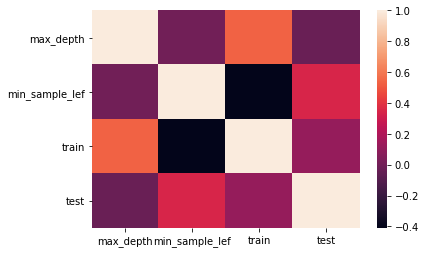

In [28]:
#plotando a correlação
sns.heatmap(corr)

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_sample_lef', ylabel='max_depth'>,
        <AxesSubplot:xlabel='train', ylabel='max_depth'>,
        <AxesSubplot:xlabel='test', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_sample_lef'>,
        <AxesSubplot:xlabel='min_sample_lef', ylabel='min_sample_lef'>,
        <AxesSubplot:xlabel='train', ylabel='min_sample_lef'>,
        <AxesSubplot:xlabel='test', ylabel='min_sample_lef'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='train'>,
        <AxesSubplot:xlabel='min_sample_lef', ylabel='train'>,
        <AxesSubplot:xlabel='train', ylabel='train'>,
        <AxesSubplot:xlabel='test', ylabel='train'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='test'>,
        <AxesSubplot:xlabel='min_sample_lef', ylabel='test'>,
        <AxesSubplot:xlabel='train', ylabel='test'>,
        <AxesSubplot:xlabel='test', ylabel='test'>]], dtype=object)

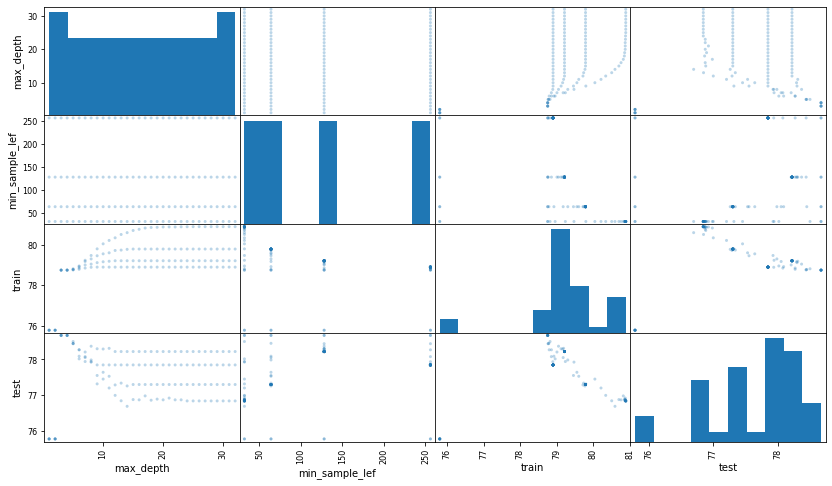

In [29]:
#comparando os valores da correlação pela matriz
from pandas.plotting import scatter_matrix

scatter_matrix(resultados, figsize=(14, 8), alpha =0.3)

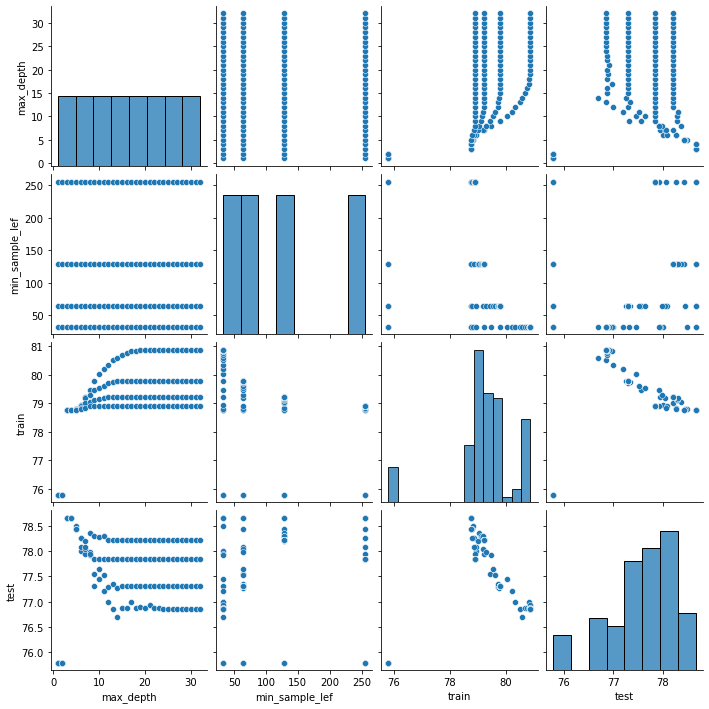

In [30]:
#plotando pareado
sns.pairplot(resultados)

max_depth aumenta o teste cai e o treino sobe

**Seaborn Correlation** parece ser o mais adequado

<AxesSubplot:>

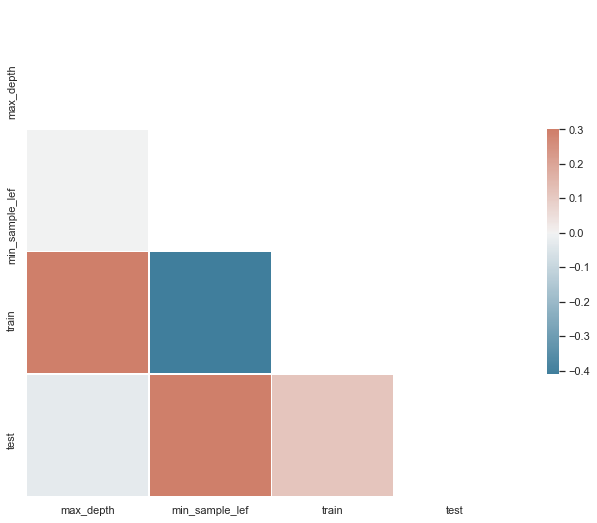

In [31]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Maior min sample lef maior foi a qualidade do teste

In [32]:
#Criando uma função para arvore de 1 a  32 no max_depth e no min samples mas agora alterando os pontos do min lef
def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [128,192, 256,512]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns =["max_depth", "min_sample_lef", "train", "test"])
    return  resultados
resultados = busca()
resultados.head()

max_depth = 1, min_samples_lef = 128, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 192, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 256, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 512, treino = 75.79, teste = 75.78
max_depth = 2, min_samples_lef = 128, treino = 75.79, teste = 75.78
max_depth = 2, min_samples_lef = 192, treino = 75.79, teste = 75.78
max_depth = 2, min_samples_lef = 256, treino = 75.79, teste = 75.78
max_depth = 2, min_samples_lef = 512, treino = 75.79, teste = 75.78
max_depth = 3, min_samples_lef = 128, treino = 78.75, teste = 78.67
max_depth = 3, min_samples_lef = 192, treino = 78.75, teste = 78.67
max_depth = 3, min_samples_lef = 256, treino = 78.75, teste = 78.67
max_depth = 3, min_samples_lef = 512, treino = 77.53, teste = 77.50
max_depth = 4, min_samples_lef = 128, treino = 78.75, teste = 78.67
max_depth = 4, min_samples_lef = 192, treino = 78.75, teste = 78.67
max_depth = 4, min_samples_lef = 256, treino = 7

,max_depth,min_sample_lef,train,test
0,1,128,75.791169,75.784219
1,1,192,75.791169,75.784219
2,1,256,75.791169,75.784219
3,1,512,75.791169,75.784219
4,2,128,75.791169,75.784219


In [33]:
#correlação do resultado
corr = resultados.corr()
corr

,max_depth,min_sample_lef,train,test
max_depth,1.000000e+00,6.863211e-17,0.354588,0.240852
min_sample_lef,6.863211e-17,1.000000e+00,-0.637649,-0.440661
train,3.545878e-01,-6.376494e-01,1.000000,0.909222
test,2.408525e-01,-4.406611e-01,0.909222,1.000000


<AxesSubplot:>

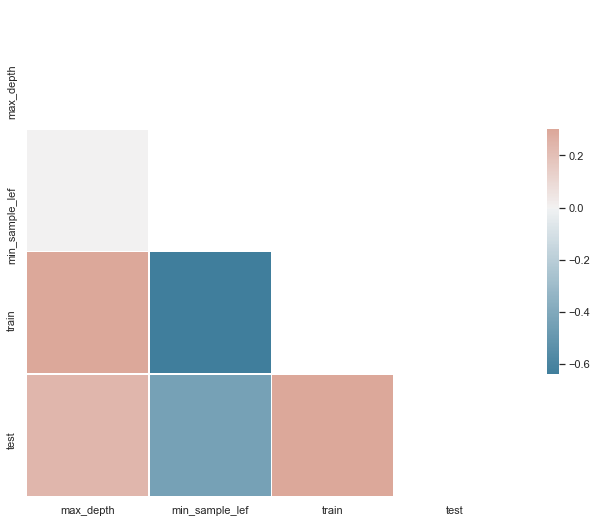

In [34]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

a medida que aumentou o min sample lef o teste caiu, nesse caso uma correlação negativa

In [35]:
#Vendo os 5 melhores resultados na utilizção do hiperparêmetro
resultados.sort_values("test", ascending=False).head()

,max_depth,min_sample_lef,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


 ### Explorando Hiperparâmetros em 3 dimensão

In [36]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10) #treinando 10 vezes o modelo
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf,min_samples_split=min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups = dados.modelo, return_train_score=True) 
    train_score = results['train_score'].mean() *100
    test_score = results['test_score'].mean() *100
    print("max_depth = %d, min_samples_lef = %d, min_samples_split = %d, treino = %.2f, teste = %.2f" % (max_depth,min_samples_leaf,min_samples_split, train_score, test_score)) #dados de teste e treino
    tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score]
    return tabela
    
#Criando uma função para arvore de 1 a  32 no max_depth e no min samples, que define a "localização" onde o algoritmo ira testar e treinar os dados. min_samples_split que definine o 
#minimo permitido
def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns =["max_depth", "min_sample_lef","min_samples_split", "train", "test"])
    return  resultados
resultados = busca()
resultados.head()

max_depth = 1, min_samples_lef = 32, min_samples_split = 32, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 32, min_samples_split = 64, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 32, min_samples_split = 128, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 32, min_samples_split = 256, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 64, min_samples_split = 32, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 64, min_samples_split = 64, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 64, min_samples_split = 128, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 64, min_samples_split = 256, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 128, min_samples_split = 32, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 128, min_samples_split = 64, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_lef = 128, min_samples_split = 128, treino = 75.79, teste

,max_depth,min_sample_lef,min_samples_split,train,test
0,1,32,32,75.791169,75.784219
1,1,32,64,75.791169,75.784219
2,1,32,128,75.791169,75.784219
3,1,32,256,75.791169,75.784219
4,1,64,32,75.791169,75.784219


In [37]:
corr = resultados.corr()
corr

,max_depth,min_sample_lef,min_samples_split,train,test
max_depth,1.000000e+00,1.300685e-16,4.182375e-16,0.529391,0.011529
min_sample_lef,1.300685e-16,1.000000e+00,0.000000e+00,-0.341222,0.286555
min_samples_split,4.182375e-16,0.000000e+00,1.000000e+00,-0.126171,0.132827
train,5.293913e-01,-3.412220e-01,-1.261715e-01,1.000000,0.247850
test,1.152853e-02,2.865546e-01,1.328271e-01,0.247850,1.000000


<AxesSubplot:>

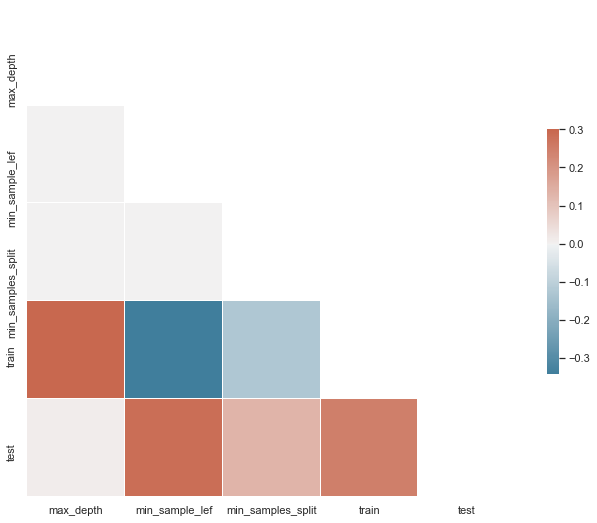

In [38]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [39]:
#Vendo os 5 melhores resultados na utilizção do hiperparêmetro
resultados.sort_values("test", ascending=False).head()

,max_depth,min_sample_lef,min_samples_split,train,test
63,4,256,256,78.750993,78.672633
48,4,32,32,78.750993,78.672633
34,3,32,128,78.750993,78.672633
35,3,32,256,78.750993,78.672633
36,3,64,32,78.750993,78.672633


### Explorando Hiperparâmetros com GridSearch
#### Utilizando GridSearch - busca de hiperparâmetros em grid, com validação cruzada

In [40]:
#importando bibliotrca
from sklearn.model_selection import GridSearchCV

In [41]:
#definindo semente para n gerar aleatoriedade
#serao 4 dimensoes com 36 combinações no total
np.random.seed(SEED)

espaco_parametros = {
    "max_depth": [3,5],
    "min_samples_split": [32,64,128],
    "min_samples_leaf": [32,64,128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(), 
                     espaco_parametros,
                     cv = GroupKFold(n_splits =10))
#treinando o modelo
busca.fit(x_azar, y_azar, groups = dados.modelo) 
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021824,0.003137,0.003966,0.000494,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.020375,0.001108,0.004422,0.000605,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.021079,0.001183,0.004019,0.000416,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.017964,0.003169,0.003819,0.001111,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.021755,0.003617,0.004750,0.001262,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [46]:
#os melhores parametros
print(busca.best_params_)
print(busca.best_score_ *100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [48]:
#melhor estimados
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

**desconsiderar abordagem abaixo pois estaremos muito otimista com o modelo**, pois os dados ja estao viciados 

In [50]:
#verificando como o modelo se comporta com os dados reais
from sklearn.metrics import accuracy_score

predicoes = melhor.predict(x_azar)
acuracia = accuracy_score(predicoes, y_azar) *100
print("Acurácia para os dados  foi de %.2f%%" % acuracia)

Acurácia para os dados  foi de 78.75%


#### Como ter essa estimativa sem esse vicio nos dados q ja foram rodados?

No caso de validação cruzada  com busca de hiperparâmetros, fazemos uma nova validação cruzada. Nesse caso, nested cross validation 

In [52]:
#importando biblioteca
from sklearn.model_selection import cross_val_score

In [53]:
#fazendo cross validation para busca inteira
scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 841, in fit
    self._run_search(evaluate_candidates)
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1288, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 807, in evaluate_candidates
    (split_idx, (train, test)) in product(
  File "D:\Anaconda3\lib\site-packages

**O pandas n suporta nested validation com group k fold nao conseguimso prever o resultado para novos grupos**

In [55]:
from sklearn.model_selection import KFold

#definindo semente para n gerar aleatoriedade
#serao 4 dimensoes com 36 combinações no total
np.random.seed(SEED)

espaco_parametros = {
    "max_depth": [3,5],
    "min_samples_split": [32,64,128],
    "min_samples_leaf": [32,64,128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(), 
                     espaco_parametros,
                     cv = KFold(n_splits =5, shuffle=True))
#treinando o modelo
busca.fit(x_azar, y_azar) 
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008678,0.001564,0.001937,0.000566,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
1,0.007687,0.000332,0.001389,0.000198,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
2,0.007987,0.001097,0.001389,0.000298,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
3,0.008035,0.000987,0.001340,0.000228,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
4,0.007393,0.000261,0.001385,0.000290,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1


In [56]:
#fazendo cross validation para busca inteira
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=10, shuffle=True))

In [59]:
#criando uma função para facilitar ao printar os dados
def imprime_scores(scores):
    media = scores.mean()  * 100
    desvio_padrao = scores.std() *100
    print("Acurácia média %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio_padrao, media + 2 * desvio_padrao))

In [60]:
imprime_scores(scores)

Acurácia média 78.69
Intervalo [76.13, 81.25]


In [62]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


#### Melhor Modelo

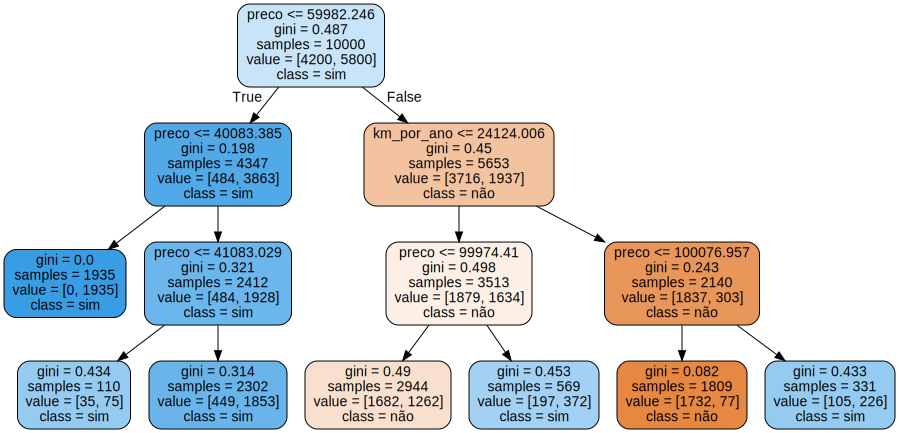

In [63]:
#Plotando artove
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True, class_names=["não", "sim"],
               feature_names=features)

graph = graphviz.Source(dot_data)
graph

Devem ser maior que 32(samples), splits tem que ser no minimo 32 samples, serão 3  nós para decisão (max_depth), usado criterio de gini para tomar decisao de quebra


### Busca Aleatória : Random Search

In [67]:
#importando biblioteca
from sklearn.model_selection import RandomizedSearchCV

In [75]:
SEED=301
np.random.seed(SEED)

espaco_parametros = {
    "max_depth": [3,5],
    "min_samples_split": [32,64,128],
    "min_samples_leaf": [32,64,128],
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), 
                     espaco_parametros, n_iter = 16,
                     cv = KFold(n_splits =5, shuffle=True), random_state= SEED)
#treinando o modelo
busca.fit(x_azar, y_azar) 
resultados = pd.DataFrame(busca.cv_results_)
resultados.head() 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011917,0.001692,0.002275,5.979998e-04,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.784,0.769,0.7985,0.793,0.7730,0.7835,0.011278,13
1,0.007142,0.000243,0.001590,2.026797e-04,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
2,0.007638,0.000742,0.001489,3.234067e-07,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
3,0.013094,0.000919,0.001984,3.134912e-04,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7
4,0.013596,0.001948,0.001583,2.009219e-04,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7


In [76]:
#fazendo cross validation para busca inteira
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))

In [77]:
imprime_scores(scores)

Acurácia média 78.67
Intervalo [76.40, 80.94]


In [80]:
#escolhendo melhor estimador com os parametros
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=64)


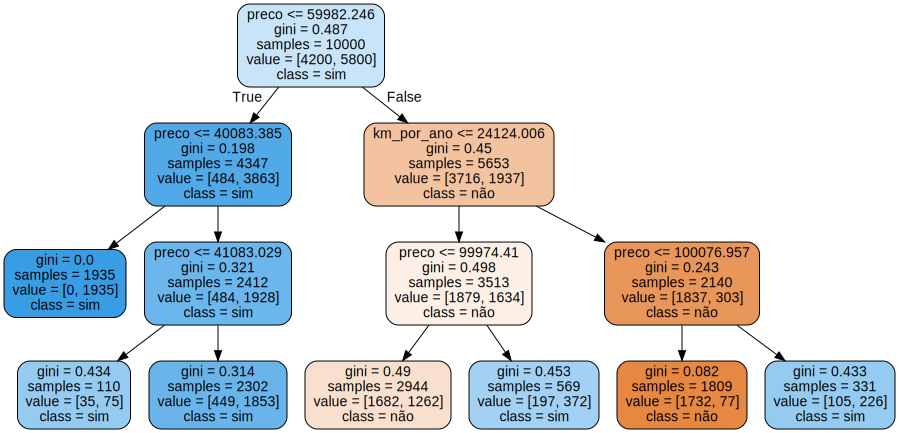

In [81]:
#Plotando artove
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True, class_names=["não", "sim"],
               feature_names=features)

graph = graphviz.Source(dot_data)
graph

Nesse modelo min samples split é 64 nao 32

### Customizando o espaço de hiperparâmetros

In [82]:
#Importando scipy
from scipy.stats import randint

In [83]:
np.random.seed(SEED)

espaco_parametros = {
    "max_depth": [3,5, 10, 15, 20, 30, None],
    "min_samples_split": randint(32,128), #gerando numeros aleatorios a medida que o modelo vai pedidindo, não uma unica vez
    "min_samples_leaf": randint(32,128),
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), 
                     espaco_parametros, n_iter = 16,
                     cv = KFold(n_splits =5, shuffle=True), random_state= SEED)
#treinando o modelo
busca.fit(x_azar, y_azar) 
resultados = pd.DataFrame(busca.cv_results_)
resultados.head() 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010514,0.001550,0.001997,0.000526,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.012201,0.000243,0.001491,0.000005,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.011316,0.000364,0.001389,0.000197,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.015557,0.001916,0.001901,0.000802,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.012301,0.001810,0.001480,0.000013,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


In [93]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_scores(scores)

Acurácia média 78.68
Intervalo [77.91, 79.45]


In [94]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


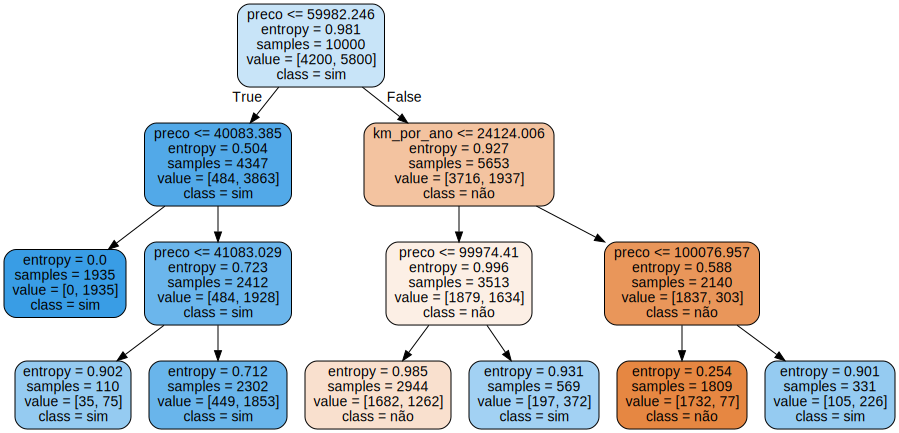

In [95]:
#Plotando árvore
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True, class_names=["não", "sim"],
               feature_names=features)

graph = graphviz.Source(dot_data)
graph

Devem ser maior que 71(samples), splits tem que ser no minimo 100 samples, serão 3 nós para decisão (max_depth), usado criterio de entropy para tomar decisao de quebra

In [126]:
#vamos iterar pelas linhas com iterrows e verificando a média da ácuracia dos testes pelo maior
resultados_ordenados_por_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_por_media.iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))          

0.776 +-(0.014) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 84, 'min_samples_split': 89, 'n_estimators': 48}
0.776 +-(0.010) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 127, 'min_samples_split': 121, 'n_estimators': 33}
0.776 +-(0.008) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 119, 'min_samples_split': 73, 'n_estimators': 16}
0.776 +-(0.011) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 117, 'min_samples_split': 36, 'n_estimators': 47}
0.776 +-(0.012) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 59, 'min_samples_split': 53, 'n_estimators': 78}
0.776 +-(0.011) {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 92, 'min_samples_split': 91, 'n_estimators': 83}
0.776 +-(0.011) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 86, 'min_samples_split': 86, 'n_estim

### Exploração mais a fundo de forma aleatória

In [103]:
np.random.seed(SEED)

espaco_parametros = {
    "max_depth": [3,5, 10, 15, 20, 30, None],
    "min_samples_split": randint(32,128), #gerando numeros aleatorios a medida que o modelo vai pedidindo, não uma unica vez
    "min_samples_leaf": randint(32,128),
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), 
                     espaco_parametros, n_iter = 64, #64 buscas aleatoria
                     cv = KFold(n_splits =5, shuffle=True), random_state= SEED)
#treinando o modelo
busca.fit(x_azar, y_azar) 
resultados = pd.DataFrame(busca.cv_results_)
resultados.head() 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010018,0.000578,0.001986,0.000315,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.012399,0.000544,0.001687,0.000243,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,46
2,0.011308,0.000371,0.001588,0.000198,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,27
3,0.014483,0.000371,0.001687,0.000397,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,64
4,0.011904,0.000941,0.001885,0.000371,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,26


In [104]:
#vamos iterar pelas linhas com iterrows e verificando a média da ácuracia dos testes pelo maior
resultados_ordenados_por_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_por_media.iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 69, 'min_samples_split': 124}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 63, 'min_samples_split': 88}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 67, 'min_samples_split': 76}
0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 65, 'min_samples_split': 50}
0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 120, 'min_samples_split': 46}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 111}
0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 106, 'min_samples_split': 108}
0.784 +-(0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.784 +-(0.024) {'criterion': 'gini', 'max_depth': 5, '

In [105]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_scores(scores)

Acurácia média 78.66
Intervalo [76.79, 80.53]


In [106]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


### Comparando GridSearchCV com RandomizedSearch - 1 comparação

In [107]:
#usando conjunto de classificadores, que vai atuar de forma conjunta de que um modelo ajuda outro modelo.
from sklearn.ensemble import RandomForestClassifier

In [108]:
#descobri o tempo q leva
import time

In [112]:
np.random.seed(SEED)

espaco_parametros = {
    'n_estimators': [10,100],
    "max_depth": [3,5],
    "min_samples_split": [32,64,128],
    "min_samples_leaf": [32,64,128],
    "bootstrap" : [True, False], #bootstrap é para controlar o sobreajuste (overfit) e a acurácia (accuracy)
    "criterion" : ["gini", "entropy"]
}

tic = time.time()
busca = GridSearchCV(RandomForestClassifier(), 
                     espaco_parametros,
                     cv = KFold(n_splits = 5, shuffle=True))
#treinando o modelo
busca.fit(x_azar, y_azar) 
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 151.47 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028788,0.003286,0.003950,0.000534,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.244431,0.006933,0.018252,0.000658,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.026678,0.000666,0.003274,0.000243,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.236882,0.003889,0.018168,0.000589,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.025390,0.000488,0.003477,0.000314,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


In [113]:
#Iterando pelas linhas  e verificando a média da ácuracia dos testes pelo maior resultado, com os hiperparâmetros
resultados_ordenados_por_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_por_media[:5].iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


In [114]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_scores(scores)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


melhor = busca.best_estimator_
print(melhor)

Acurácia média 76.78
Intervalo [75.74, 77.82]
Tempo 620.68 segundos
RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=32,
                       min_samples_split=64, n_estimators=10)


In [121]:
np.random.seed(SEED)

espaco_parametros = {
    'n_estimators': [10,100],
    "max_depth": [3,5],
    "min_samples_split": [32,64,128],
    "min_samples_leaf": [32,64,128],
    "bootstrap" : [True, False], #bootstrap é para controlar o sobreajuste (overfit) e a acurácia (accuracy)
    "criterion" : ["gini", "entropy"]
}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(), 
                     espaco_parametros,
                     n_iter =20,
                     cv = KFold(n_splits = 5, shuffle=True))
#treinando o modelo
busca.fit(x_azar, y_azar) 
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 22.13 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.293336,0.007392,0.018839,0.000757,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7740,0.7925,0.7775,0.7560,0.7742,0.011724,10
1,0.038884,0.002114,0.004068,0.000485,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.750,0.7785,0.7820,0.7785,0.7645,0.7707,0.011969,13
2,0.378338,0.008513,0.021539,0.000741,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7745,0.7930,0.7785,0.7585,0.7751,0.011178,6
3,0.026685,0.001148,0.003472,0.000314,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.750,0.7600,0.7450,0.7390,0.7520,0.7492,0.007026,20
4,0.042259,0.004736,0.003869,0.000199,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.771,0.7740,0.7635,0.7370,0.7585,0.7608,0.013094,18


In [122]:
#Iterando pelas linhas  e verificando a média da ácuracia dos testes pelo maior resultado, com os hiperparâmetros
resultados_ordenados_por_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_por_media[:5].iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.776 +-(0.025) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.776 +-(0.023) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
0.776 +-(0.024) {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.776 +-(0.032) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
0.775 +-(0.035) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}


In [123]:
#estimando dados do futuro
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_scores(scores)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


melhor = busca.best_estimator_
print(melhor)

Acurácia média 77.59
Intervalo [76.47, 78.71]
Tempo 94.17 segundos
RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=32,
                       min_samples_split=32)


In [146]:
np.random.seed(SEED)

espaco_parametros = {
    'n_estimators': randint(10,101),
    "max_depth": randint(3,5),
    "min_samples_split": randint(32,129),
    "min_samples_leaf": randint(32,129),
    "bootstrap" : [True, False], #bootstrap é para controlar o sobreajuste (overfit) e a acurácia (accuracy)
    "criterion" : ["gini", "entropy"]
}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(), 
                     espaco_parametros,
                     n_iter = 80, #definindo 80 iterações
                     cv = KFold(n_splits = 5, shuffle=True))
#treinando o modelo
busca.fit(x_azar, y_azar) 
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 81.38 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.234814,0.005948,0.014384,0.000313,False,gini,4,100,50,71,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7775,0.7700,0.7835,0.7760,0.7680,0.7750,0.005541,32
1,0.246802,0.022625,0.013988,0.000958,False,entropy,3,108,124,66,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7775,0.7700,0.7840,0.7765,0.7680,0.7752,0.005715,21
2,0.171424,0.010296,0.015178,0.003786,True,gini,3,62,56,62,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7790,0.7705,0.7830,0.7765,0.7675,0.7753,0.005627,15
3,0.152274,0.008456,0.011111,0.001278,False,gini,3,80,57,51,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7770,0.7705,0.7835,0.7785,0.7680,0.7755,0.005595,11
4,0.170527,0.011907,0.012900,0.000766,True,gini,3,101,52,66,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7775,0.7695,0.7750,0.7770,0.7680,0.7734,0.003917,55


In [125]:
#Iterando pelas linhas  e verificando a média da ácuracia dos testes pelo maior resultado, com os hiperparâmetros
resultados_ordenados_por_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_por_media[:5].iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.776 +-(0.014) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 84, 'min_samples_split': 89, 'n_estimators': 48}
0.776 +-(0.010) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 127, 'min_samples_split': 121, 'n_estimators': 33}
0.776 +-(0.008) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 119, 'min_samples_split': 73, 'n_estimators': 16}
0.776 +-(0.011) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 117, 'min_samples_split': 36, 'n_estimators': 47}
0.776 +-(0.012) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 59, 'min_samples_split': 53, 'n_estimators': 78}


In [127]:
#estimando dados do futuro
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_scores(scores)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


melhor = busca.best_estimator_
print(melhor)

Acurácia média 77.37
Intervalo [76.10, 78.64]
Tempo 348.89 segundos
RandomForestClassifier(bootstrap=False, max_depth=4, min_samples_leaf=84,
                       min_samples_split=89, n_estimators=48)


### Treino  Teste   e Validação, otimização sem Validação Cruzada

da pra utilizar, mas perdemos o ganho da valdidação cruzada em si, entao só casos especificos fariamos dessa forma

In [128]:
#importando stratifiedshufflesplit, q vai aleatorizar a ordem e quberar de acordo com a estratificação das classes passadas para o modelo
from sklearn.model_selection import StratifiedShuffleSplit

In [133]:
#antes de rodar devemos separar 
# 60% para treino
# 20% teste
# 20% validação
from sklearn.model_selection import train_test_split 

SEED = 301
np.random.seed(SEED)

x_treino_teste, x_validacao, y_treino_teste, y_validacao=  train_test_split(x_azar, y_azar , test_size=0.2,  shuffle=True, stratify=y_azar)

In [139]:
SEED = 301
np.random.seed(SEED)

#Passando o split
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.25) #quebrar uma unica vez e o tamnho do teste será de 25%, 75% fica p treino

espaco_parametros = {
    'n_estimators': randint(10,101),
    "max_depth": randint(3,5),
    "min_samples_split": randint(32,129),
    "min_samples_leaf": randint(32,129),
    "bootstrap" : [True, False], #bootstrap é para controlar o sobreajuste (overfit) e a acurácia (accuracy)
    "criterion" : ["gini", "entropy"]
}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(), 
                     espaco_parametros,
                     n_iter = 5, #definindo 80 iterações
                     cv = split)
#treinando o modelo
busca.fit(x_treino_teste, y_treino_teste) 
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 1.16 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.211792,0.0,0.022850,0.0,False,gini,4,100,50,71,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7745,0.7745,0.0,1
1,0.205374,0.0,0.013858,0.0,False,entropy,3,108,124,66,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7735,0.7735,0.0,2
2,0.130483,0.0,0.012399,0.0,True,gini,3,62,56,62,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7730,0.7730,0.0,5
3,0.119040,0.0,0.010911,0.0,False,gini,3,80,57,51,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7735,0.7735,0.0,2
4,0.142816,0.0,0.013887,0.0,True,gini,3,101,52,66,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7735,0.7735,0.0,2


In [144]:
#estimando dados do futuro
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv = split)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)
scores

Tempo 0.47 segundos


array([0.76])